# K-Mean Clustering

K-means clustering is a type of unsupervised learning, which is used when we have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable `k`. 

The algorithm works iteratively to assign each data point to one of `k` groups based on the features that are provided. Data points are clustered based on *feature similarity*. 

In this lab, we will look at how to separate 45,000 movies into different groups based on their synopsis. Let's load the data using the following code.



In [1]:
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
from sklearn import feature_extraction

In [2]:
full_set = pd.read_csv('https://github.com/chailing/trainerdata/blob/master/movie_overview.csv?raw=true')
full_set = full_set.dropna() #remove movies where overview or title is null

In [3]:
# sampling a subset of the full dataset for tutorial purpose
# We set the random state to make sure that the results is reproducible
df = full_set.sample(1000, random_state=456) #data frame
df.head()

,id,title,overview
30959,30959,The Concubine,"Set during the early Joseon Dynasty, the film ..."
35044,35044,The Visitors,"Frank, Sara and their two children have recent..."
3857,3857,What's Cooking?,"In LA's Fairfax district, where ethnic groups ..."
24117,24117,Tattoo Nation,A documentary that follows three pioneers -- C...
25583,25583,Madea's Big Happy Family,"Shirley has important news for her family, but..."


## Feature Extraction

Now we have gotten our data, what we want to do next is to perform clustering. But before we begin, we will need to construct the feature by turning text into numbers. Similar to what we did before in the supervised learning chapter. We are not going to do it manually this time, instead, we are using the **TF-IDF** Vectorizer from `sklearn` to help us. We first construct an Vectorizer with English stopwords, then constructure the feature set.



In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract the movie overviews
documents = df['overview'].values.astype("U") # U mean UTF

# Initialize our TF-IDF vectorizer - TF : text frequency, how many in a doc, IDF - inverse doc, many docs / freq
vectorizer = TfidfVectorizer(max_features=200000, stop_words='english', min_df = 5,
                             use_idf=True, ngram_range=(1,3))

tfidf_matrix = vectorizer.fit_transform(documents) #fit the vectorizer to synopses



## Model Fitting

Once we have gotten our features, we can proceed to analyze them using K-Mean clustering. Let's get to algorithm to create $k$ clusters for us.

Depends on the processing power of your machine, this will take a little while. We may use a %time magic code to help us to calculate the time taken.

In [5]:
from sklearn.cluster import KMeans

k = 9

#modelling
km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 218 ms


Let's assign the cluster back to our dataframe, and count how the data points for each cluster.

In [6]:
df['cluster']= km.labels_
df.head(10)

,id,title,overview,cluster
30959,30959,The Concubine,"Set during the early Joseon Dynasty, the film ...",1
35044,35044,The Visitors,"Frank, Sara and their two children have recent...",6
3857,3857,What's Cooking?,"In LA's Fairfax district, where ethnic groups ...",7
24117,24117,Tattoo Nation,A documentary that follows three pioneers -- C...,8
25583,25583,Madea's Big Happy Family,"Shirley has important news for her family, but...",7
3391,3391,Return to Me,It took a lot of cajoling to get Bob (Duchovny...,6
25396,25396,The Frame,Two strangers find their lives colliding in an...,6
33049,33049,Pawn Sacrifice,American chess champion Bobby Fischer prepares...,6
11044,11044,Beyond the Rocks,A young woman marries an older millionaire and...,1
1811,1811,Small Soldiers,When missile technology is used to enhance toy...,6


In [7]:
df['cluster'].value_counts()

6    376
8    113
5     98
1     91
7     80
0     71
2     68
4     56
3     47
Name: cluster, dtype: int64

Now if you inspect the results, it looks all right but we cannot really understand why and how the algorithms group these movies together. What we can do is to check the centroid of each cluster. Once we know the centroid, we will know the movies that are closed to the centroids and that helps us to understand the similarities between these movies.

In [8]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
terms = vectorizer.get_feature_names()

cluster_names = {}

for i in range(k):
    print("Cluster %d:" % i)
    cluster_names[i] = ",".join([terms[j] for j in order_centroids[i, :5]])
    for j in order_centroids[i, :10]:
        print (' %s' % terms[j], end=',')
    print('\n\n')

Top terms per cluster:

Cluster 0:
 man, prison, old, life, young man, young, old man, tries, years, time,


Cluster 1:
 woman, love, falls, young, falls love, daughter, young woman, life, new, finds,


Cluster 2:
 war, old, year, year old, joe, world war, ii, country, world war ii, war ii,


Cluster 3:
 group, high, school, high school, teacher, students, force, friend, people, young,


Cluster 4:
 story, love, tells, best, true, true story, friend, best friend, based, film,


Cluster 5:
 film, life, based, documentary, times, movie, director, american, directed, mother,


Cluster 6:
 town, young, friends, overview, small, men, people, new, american, help,


Cluster 7:
 family, boy, finds, father, home, children, young, life, child, friends,


Cluster 8:
 world, city, new, wife, york, new york, fight, order, help, evil,




In [19]:
print(cluster_names)

{0: 'man,prison,old,life,young man', 1: 'woman,love,falls,young,falls love', 2: 'war,old,year,year old,joe', 3: 'group,high,school,high school,teacher', 4: 'story,love,tells,best,true', 5: 'film,life,based,documentary,times', 6: 'town,young,friends,overview,small', 7: 'family,boy,finds,father,home', 8: 'world,city,new,wife,york'}


## Visualizing Clusters

### Principal Component Analysis (PCA)
As text documents are highly dimensional type of data, therefore we cannot simply visualize it like normal numerical data. We will need to to convert the dist matrix into a 2-dimensional array using principle component analysis (PCA). 

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.todense())
xs, ys = reduced_data[:, 0], reduced_data[:, 1]

Once we have reduced the dimension of our dataset to 2-dimensional, we can then visualize using normal chart.

In [13]:
groups.head()

,x,y,label,title
0,0.154699,0.173089,1,The Concubine
1,-0.015190,-0.010363,6,The Visitors
2,0.164509,-0.008454,7,What's Cooking?
3,-0.149307,-0.017937,8,Tattoo Nation
4,0.072230,-0.032395,7,Madea's Big Happy Family
5,-0.032133,-0.021055,6,Return to Me
6,-0.049610,-0.095821,6,The Frame
7,-0.082911,-0.036917,6,Pawn Sacrifice
8,0.302121,0.179668,1,Beyond the Rocks
9,-0.042810,-0.040200,6,Small Soldiers


In [15]:
for name, group in groups:
    print(name)

0
1
2
3
4
5
6
7
8


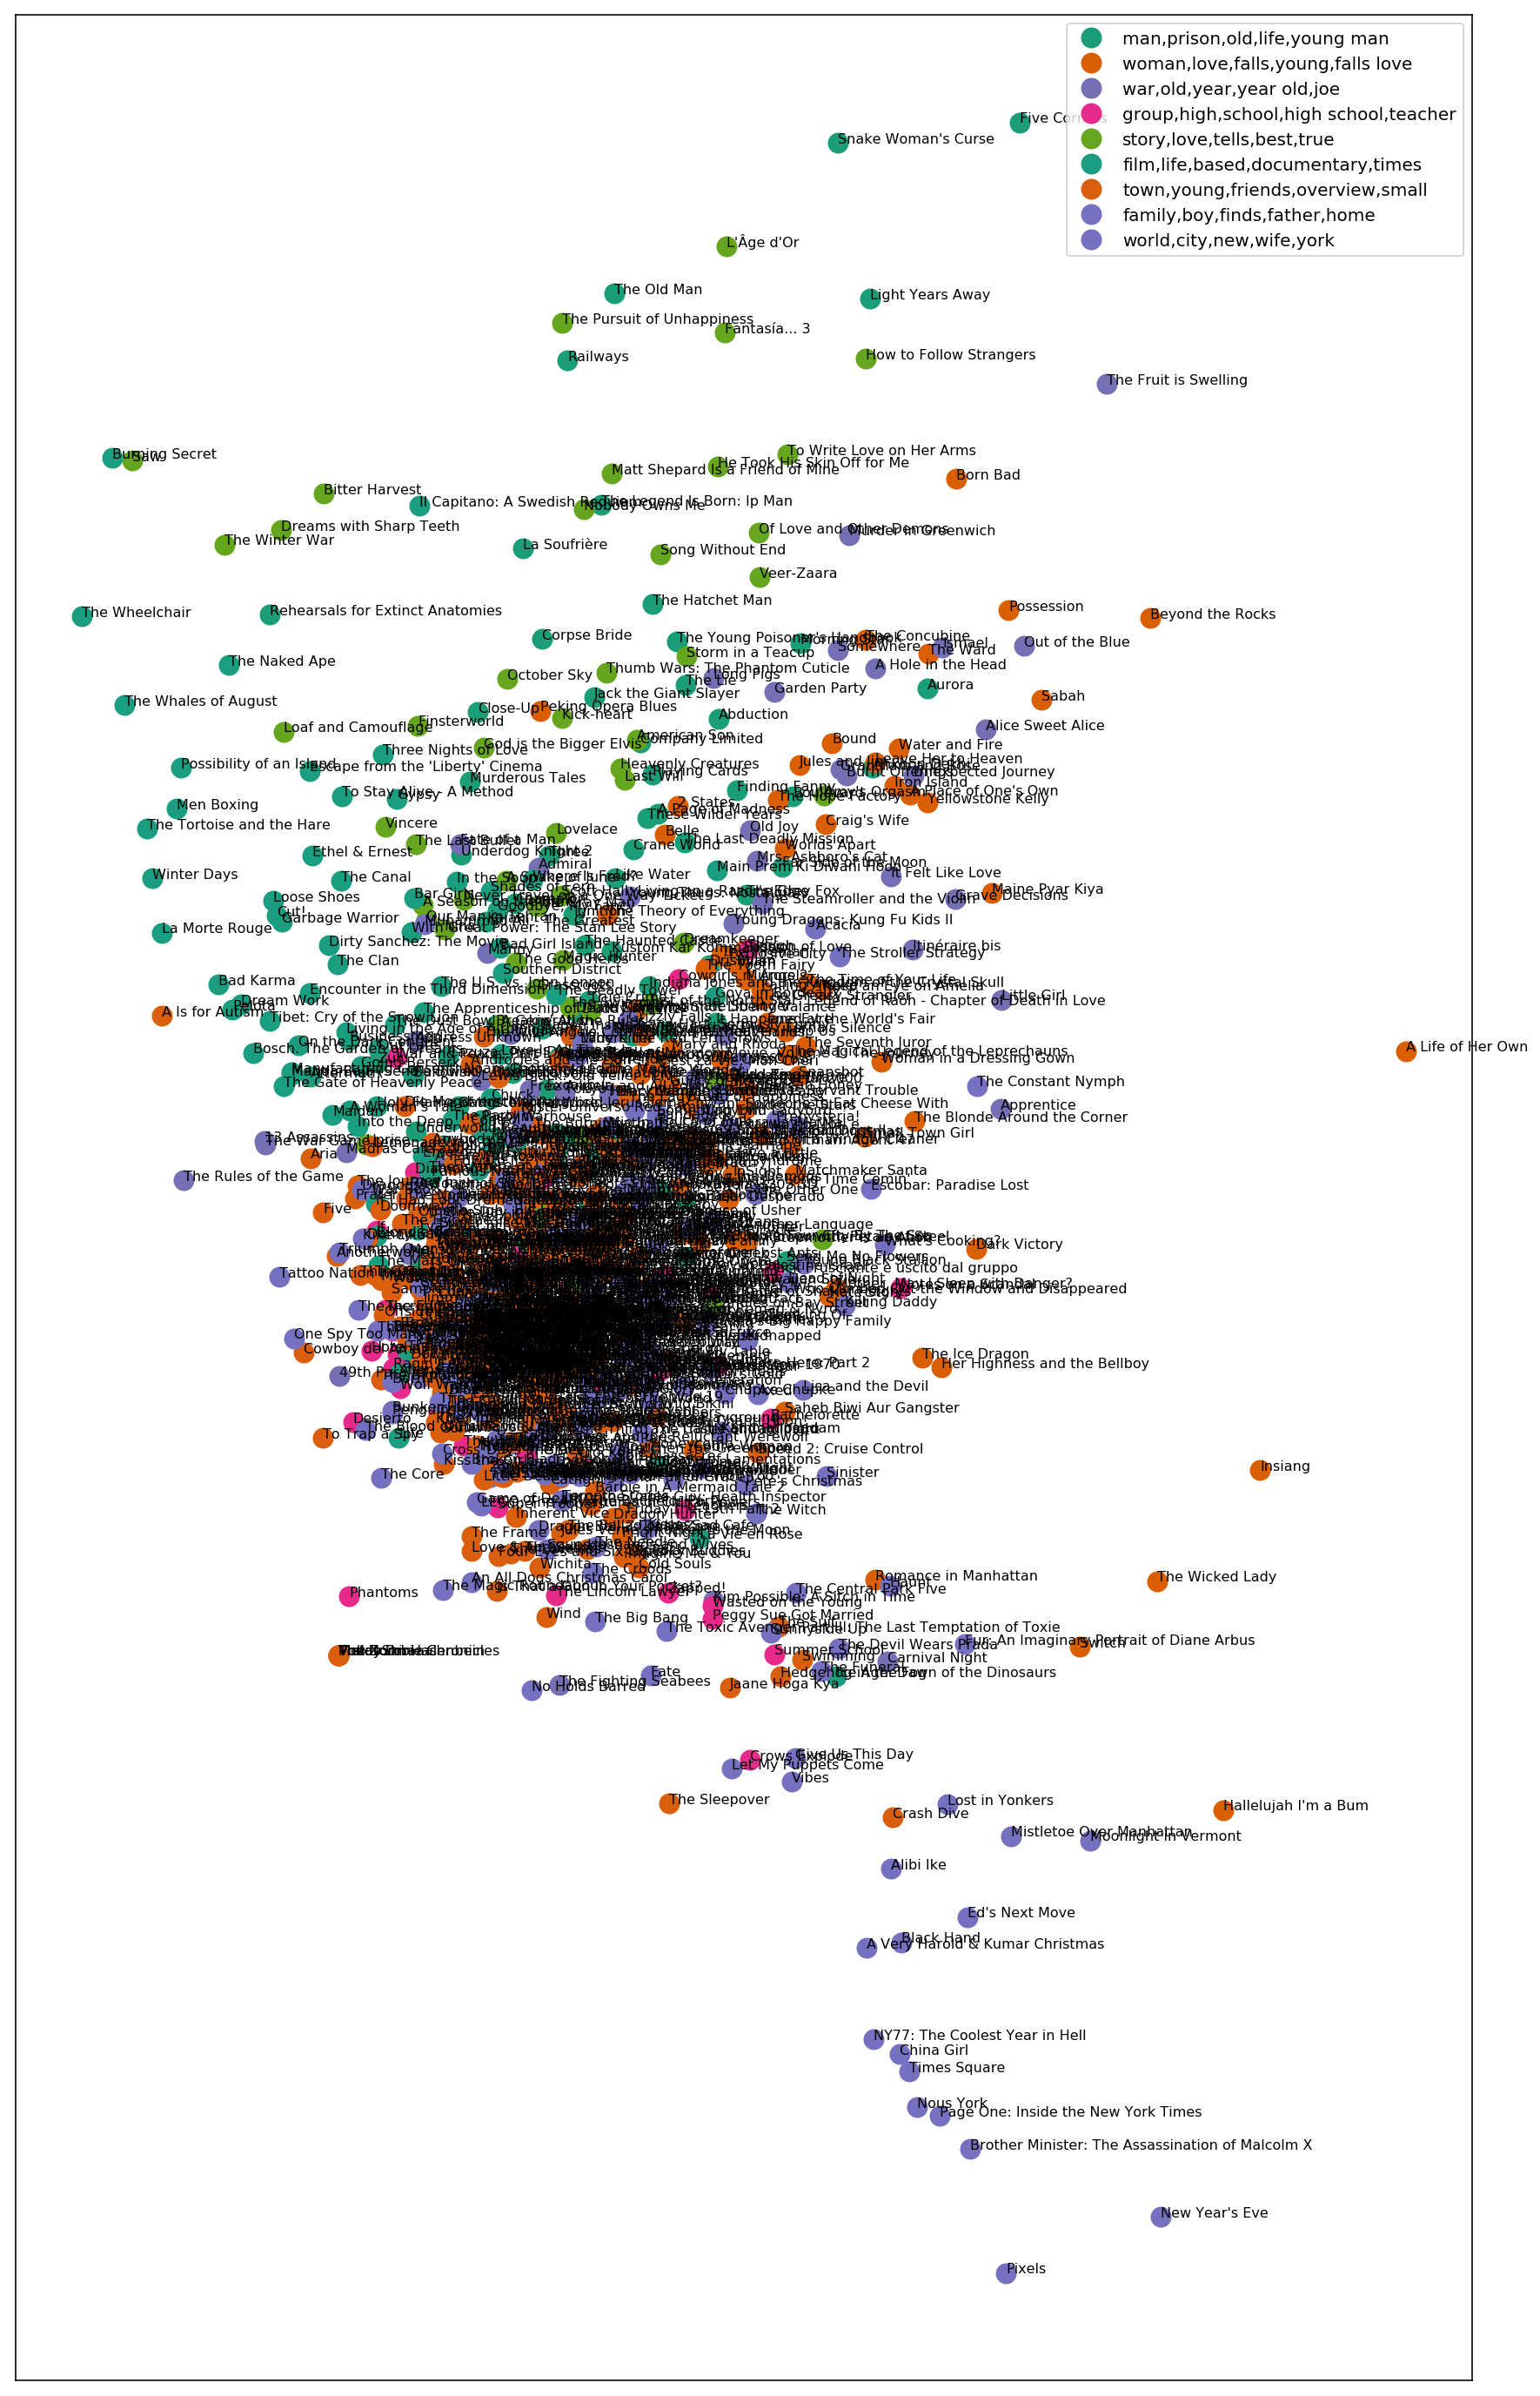

In [41]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 
import matplotlib.pyplot as plt

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                  5: '#1b9e7f', 6: '#d95f0f', 7: '#7570bf', 8: '#7570bf', 9: '#66f61f'
                 }

#create data frame that has the result of the PCA plus the cluster numbers and movie titles
titles = df['title'].tolist()
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(15, 25)) # set size

#iterate through groups to layer the plot

#for name, group in groups:
#    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
#             label=cluster_names[name],
#             color=cluster_colors[name], 
#             mec='none')
    
for name, group in groups:
    ax.plot(\
        group.x, 
        group.y, 
        marker='o', 
        linestyle='', 
        ms=12, 
        label=cluster_names[name], 
        color=cluster_colors[name], 
        mec='none')
    
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
plt.show()

## Exercise

You may try the following on your own 
- Adjust the size of dataset (n > 100) or (n < 100)
- Adjust the number of clusters